In [39]:
import sys
sys.path.append('../../../misc/mmelo-misc')

from helpers import pd, np, plt, h2o, sk, hlp

%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn import *
from xgboost.sklearn import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print train.describe()
print train.select_dtypes(['object']).describe()

       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
                             Name   Sex    Ticket        Cabin Embarked
count                         891   891       891          204      889
unique                        891    

In [5]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [73]:
N_JOBS = -1

NOT_FEATURES = [
    'PassengerId',
    'Survived',
]

def preprocess(X):
    X = X[X.columns.difference(NOT_FEATURES)]
    
    name = X.Name.str.extract('(\w*), ([\w\s]*\.).*')
    name.columns = [ 'surname', 'title' ]
    
    cabin  = X.Cabin.str.extract('([A-Z]*)(\d*)')
    cabin.columns = [ 'cabin_1', 'cabin_2' ]
    
    ticket = X.Ticket.str.replace('\.|/', '').str.extract('([A-Z\.]+)?(/.* )?\s*(\d*)')
    ticket.columns = [ 'ticket_1', 'ticket_2', 'ticket_3' ]
    
    X = pd.concat([X, name, cabin, ticket], axis=1)
    X = X.drop(['Ticket', 'Cabin', 'Name'], axis=1)  # 'cabin_2', 'surname', 'ticket_2', 'ticket_3', axis=1)

    categorical = X.select_dtypes(['object']).columns.values.tolist() + [ 'Pclass' ]
    for c in categorical:
        X[c] = preprocessing.LabelEncoder().fit_transform(X[c])
    
    X.Fare = X.Fare.fillna(X.Fare.median())
    
    wo_age = X.Age.isnull()
    dt = pd.get_dummies(X[['Fare', 'title']], columns=['title'])
    lm = linear_model.LinearRegression().fit(dt[~wo_age], X.Age[~wo_age])
    X.Age[wo_age] = lm.predict(dt[wo_age])
    
#     X = X.fillna(X.median())
    X['family_size'] = X.SibSp + X.Parch + 1
    X['singleton'] = X.family_size.apply(lambda x: 1 if x == 1 else 0)
    X['small'] = X.family_size.apply(lambda x: 1 if x > 1 and x < 4 else 0)
    X['big'] = X.family_size.apply(lambda x: 1 if x > 4 else 0)
    X['child'] = X.Age.apply(lambda x: 1 if x > 18 else 0)
    
    cat_mask = np.in1d(X.columns, categorical)
    X_enc = preprocessing.OneHotEncoder(categorical_features=cat_mask).fit_transform(X).tocsr()
    X_enc = preprocessing.MaxAbsScaler().fit_transform(X_enc)
    
    return X, X_enc

def evaluate_cv(*args, **kwargs):
    scores = cross_validation.cross_val_score(*args, **kwargs)
    return "%f +- %f" % ( np.mean(scores), np.std(scores) )

def evaluate(model, x_train, y_train, x_test, y_test, name=""):
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)
    output = pd.DataFrame( zip(y_pred[:,1], y_test), columns=['predictions','labels'] )
    hlp.perf.classifier_performance(output, name=name)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

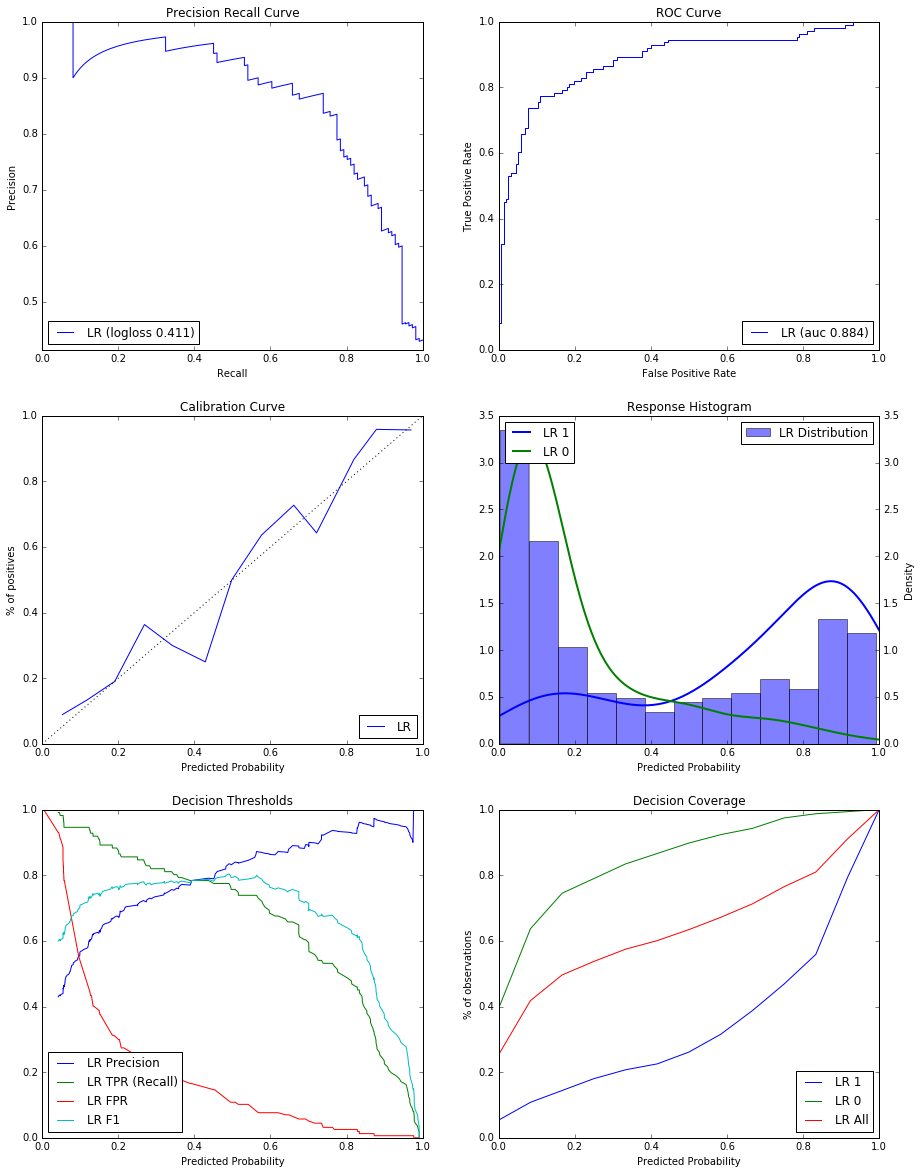

In [111]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y = train.Survived
X, X_enc = preprocess(pd.concat([train, test], axis=0))

X, X_submit = X[:train.shape[0]], X[train.shape[0]:]
X_enc, X_submit_enc = X_enc[:train.shape[0]], X_enc[train.shape[0]:]

X_train, X_test, X_enc_train, X_enc_test, y_train, y_test = \
    model_selection.train_test_split(X, X_enc, y, test_size=0.3, random_state=42)

m1 = linear_model.LogisticRegression()
evaluate(m1, X_enc_train, y_train, X_enc_test, y_test, name="LR")

# m2 = XGBClassifier(n_estimators=50, max_depth=7)
# evaluate(m2, X_train, y_train, X_test, y_test, name="XGB")
plt.show()


In [457]:
params = [
    {
        'max_depth': range(5, 21, 2),
        "min_samples_split": [ 1, 2, 3 ],
        "min_samples_leaf": [ 1, 2 ],
        "bootstrap": [ False, True ],
        "criterion": [ "entropy", "gini" ],
        "n_estimators": [ 250 ],
    }
]

grid = grid_search.GridSearchCV(m0, params, scoring='accuracy', cv = 5, n_jobs=-1, verbose=1)
grid.fit(X, y)
print grid.best_score_, grid.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 10.7min finished


0.843995510662 {'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 250, 'criterion': 'gini', 'min_samples_split': 3, 'max_depth': 15}


In [458]:
params = [
    {
        'alpha': [ .0001 ],
        "penalty": [ 'elasticnet' ],
        "l1_ratio": list(np.linspace(.00, .10, 6)) + list(np.linspace(.90, 1.00, 6)),
        "loss": [ 'log', 'hinge' ],
        "n_iter": range(50, 570, 40),
    }
]

grid2 = grid_search.GridSearchCV(m1, params, scoring='accuracy', cv = 5, n_jobs=-1, verbose=1)
grid2.fit(X_enc, y)
print grid2.best_score_, grid2.best_params_

Fitting 5 folds for each of 312 candidates, totalling 1560 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   23.4s


0.854096520763 {'penalty': 'elasticnet', 'n_iter': 530, 'alpha': 0.0001, 'l1_ratio': 0.92000000000000004, 'loss': 'hinge'}


[Parallel(n_jobs=-1)]: Done 1560 out of 1560 | elapsed:   32.4s finished


In [459]:
params = [
    {
        'max_depth': range(5, 21, 2),
        "min_child_weight": [ 1, 2, 3, 4 ],
        "gamma": [ .1, .2 ],
        'subsample': [ .8, 1 ],
        'colsample_bytree': [ .6, .7, .8 ],
        'learning_rate': [ .1 ],
    }
]

grid3 = grid_search.GridSearchCV(m2, params, scoring='accuracy', cv = 5, n_jobs=-1, verbose=1)
grid3.fit(X, y)
print grid3.best_score_, grid3.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   54.6s


0.843995510662 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 3, 'subsample': 1, 'max_depth': 7, 'gamma': 0.1}


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  1.0min finished


In [460]:
pred1 = grid.predict(X_test)
pred2 = grid2.predict(X_test_enc)
pred3 = grid3.predict(X_test)

# majority vote
pred = np.round(map(np.mean, zip(pred1, pred2, pred3))).astype('int')

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pred
})
submission.to_csv('submission.csv', index=False)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pred1
})
submission.to_csv('submission1.csv', index=False)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pred2
})
submission.to_csv('submission2.csv', index=False)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pred3
})
submission.to_csv('submission3.csv', index=False)
